Causal Effect: -0.08
Bias threshold: <0.1 (absolute value)
           demographic_parity  equalized_odds
Baseline             0.826803             1.0
Mitigated            0.982340             0.0


<Figure size 1000x600 with 0 Axes>

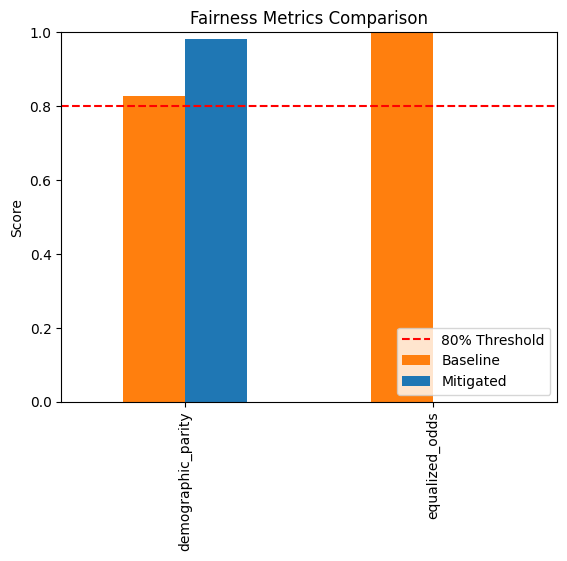

Baseline Valid: True
Mitigated Valid: False


In [4]:
# AI Bias Mitigation with DoWhy & FairLearn

!pip install dowhy fairlearn transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dowhy import CausalModel
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from sklearn.ensemble import RandomForestClassifier
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# %% [markdown]
# ## 1. Create Synthetic Dataset with Encoded Gender
# %%
np.random.seed(42)
n_samples = 1000

data = pd.DataFrame({
    'gender': np.random.choice(['male', 'female'], n_samples, p=[0.7, 0.3]),
    'education': np.random.randint(1, 5, n_samples),
    'experience': np.random.normal(5, 2, n_samples),
    'interview_score': np.random.normal(70, 15, n_samples)
})

# Encode gender to numeric values
data['gender_encoded'] = data['gender'].map({'male': 0, 'female': 1})

# Introduce bias against female candidates
data['hired'] = np.where(
    (data['gender'] == 'female') & 
    (data['interview_score'] > 75 + 5*data['education']), 
    0,  # Reject qualified females
    np.where(data['interview_score'] > 65 + 3*data['education'], 1, 0)
)

# 2. Causal Analysis with DoWhy

causal_model = CausalModel(
    data=data,
    treatment='gender_encoded',
    outcome='hired',
    common_causes=['education', 'experience', 'interview_score']
)

identified_estimand = causal_model.identify_effect()

causal_estimate = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units="att"
)

print(f"Causal Effect: {causal_estimate.value:.2f}")
print("Bias threshold: <0.1 (absolute value)")


# ## 3. Bias Mitigation with FairLearn

X = data[['education', 'experience', 'interview_score']]
y = data['hired']
sensitive_feature = data['gender_encoded']

# Baseline model
baseline_model = RandomForestClassifier()
baseline_model.fit(X, y)
baseline_pred = baseline_model.predict(X)

# Mitigate bias
constraint = DemographicParity()
mitigator = ExponentiatedGradient(
    estimator=RandomForestClassifier(),
    constraints=constraint
)

mitigator.fit(X, y, sensitive_features=sensitive_feature)
fair_pred = mitigator.predict(X)


# ## 4. Fairness Evaluation

def calculate_fairness(y_true, y_pred, sensitive_feature):
    return {
        'demographic_parity': demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_feature),
        'equalized_odds': equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_feature)
    }

baseline_metrics = calculate_fairness(y, baseline_pred, sensitive_feature)
fair_metrics = calculate_fairness(y, fair_pred, sensitive_feature)

metrics_df = pd.DataFrame([baseline_metrics, fair_metrics], 
                         index=['Baseline', 'Mitigated'])

print(metrics_df)


# ## 5. Visualization
plt.figure(figsize=(10, 6))
metrics_df.T.plot(kind='bar', color=['#ff7f0e', '#1f77b4'])
plt.title('Fairness Metrics Comparison')
plt.ylabel('Score')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.legend()
plt.ylim(0, 1)
plt.show()


# 6. Validation

def validate_mitigation(metrics):
    return all(value >= 0.8 for value in metrics.values())

print(f"Baseline Valid: {validate_mitigation(baseline_metrics)}")
print(f"Mitigated Valid: {validate_mitigation(fair_metrics)}")